# Demonstration of SMPS Calculations

The SMPS calculations require two main packages from ``atmPy`` - ``smps`` and ``dma``.  ``dma`` contains the ``DMA`` class and its children.  The children of ``DMA`` simply contain the definition of the dimensions of the DMA used in the current SMPS instance.  In this case, we use the definition of the NOAA wide DMA, which has the dimensions $r_i = 0.0312$, $r_o = 0.03613$ and $l = 0.34054$ where all units are in meters.  The ``SMPS`` object provides a set of utilities for taking the scan data, applying a transfer function and correcting the distribution for multiple charges to produce a size distribution.

The import of the ``sizedistribution`` package allows us to manipulate the output of the DMA ($dN/d\log{D_p}$) such that we can pull out other representations of the size distribution.  The remaining packages are simply used for data manipulation.

In [1]:
from atmPy.instruments.DMA import smps
from atmPy.instruments.DMA import dma
from matplotlib import colors
import matplotlib.pyplot as plt
from numpy import meshgrid
import numpy as np
import pandas as pd
from matplotlib.dates import date2num
from matplotlib import dates
from atmPy import sizedistribution as sd
%matplotlib inline

done


The first thing we do in the analysis is we create a new SMPS object with the ``DMA`` instance we wish to use.  Here, we also set the initial directory to search for SMPS data.  When a new ``SMPS`` object is created, an open file dialog window will be produced and the user may select one or many files to analyze.  The file names will be stored in the ``SMPS`` attribute ``files``.

In [2]:
hagis = smps.SMPS(dma.NoaaWide(),scan_folder="C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans")

## Determining the Lag

In order to properly analyze a scan, we must first align the data such that the particle concentrations are consistent with the conditions in the DMA.  Although conditions such as voltages and flows adjust to changes almost immediately, there will be a lag in the particle response due to isntrument residence time.  We can determine the lag either through a correlation or heuristically.  The SMPS provides a function ``getLag`` which takes an integer indicating the file index to select in the attribute ``files`` containing the array of files selected by the user.  The optional input, ``delta``, allows the user to offset the result of the correlation by some amount to provide a more reasonable estimate of the lag.

The ``SMPS::getLag`` method will produce two plots.  The first is the results from the attempted correlation and the second shows how the two scans align with the lag estimate, both the smoothed and raw data. This method will set the ``lag`` attribute in the ``SMPS`` instance which will be used in future calculations.  This attribute is directly accessible if the user wishes to adjust it.

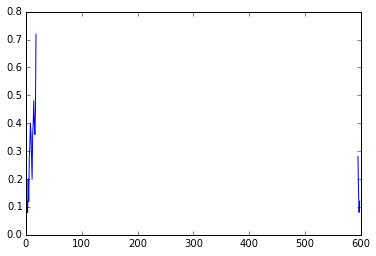

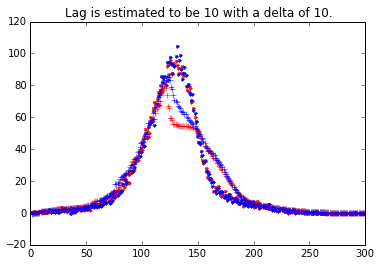

In [127]:
hagis.getLag(0, delta=10)

## Processing the Files

Once the user has pointed to the files they wish to use, they can begin processing of the files using the function ``SMPS::procFiles()``.  Each file is processed as follows:

1. The raw data concerning the conditions is truncated for both the up and down scans to the beginning and end of the respective scans.  The important parameters here are the values $t_{scan}$ and $t_{dwell}$ from the header of the files.  The range of the data from the upscan spans the indices 0 to $t_{scan}$ and the range for the down data is $t_{scan}+t_{dwell}$ to $2\times t_{scan}+t_{dwell}$.
2. The CN data is adjusted based on the lag.  This data is truncated for the up scan as $t_{lag}$ to $t_{lag} + t_{scan}$ where $t_{lag}$ is the lag time determined by the user (possibly with the function ``SMPS::getLag()``.  In the downward scan, the data array is reversed and the data is truncated to the range $t_{dwell}-t_{lag}$ to $t_{scan}+t_{dwell}-t_{lag}$.  In all cases, the CN concentration is calculated from the 1 second buffer and the CPC flow rate as $N_{1 s}/Q_{cpc}$.
3. The truncated [CN] is then smoothed using a Lowess smoothing function for both the up and down data.
4. Diameters for each of the corresponding [CN] are then calculated from the set point voltage (rather than the measured voltage).
5. The resulting diameters and smoothed [CN] are then run through a transfer function.  In this case, the transfer function is a simple full width half max based off of the mobility range of the current voltage.  This function allows us to produce a $d\log D_p$ for the ditribution.
6. The distribution is then corrected based on the algorithm described below.
7. The charge corrected distribution is then converted to a logarithmic distribution using the values from the FWHM function.
8. The resulting distribution is then interpolated onto a logarithmically distributed array that consists of bin ranging from 1 to 1000 nm.

In [4]:
hagis.proc_files()

C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_02_49.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_13_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_23_50.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_34_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_44_50.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_55_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_05_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_16_21.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_26_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_37_21.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_47_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_58_22.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_18_08_52.txt
C:/Users/mrichardson/Docu

## Charge Correction

In any charge correction, we must assume that there are no particles beyond the topmost bin.  This allows us to make the assumption that all particles in that bin are singly charged.  To determine all particles that belong in that bin that are of diameter $D_p$ with multiple charges, we can base this off of the predicted fraction of singly charged particles to multiply charged particles.  By using the following

\begin{equation}
\frac{N_i(D_p,i)}{f_i}=N(D_p)
\end{equation}

where $N_i$ is the number of particles of size $D_p$ having $i$ charges, $f_i$ is the charging efficiency for $i$ particles and $N(D_p)$ is the total number of particles expected having diameter $D_p$.  Since we assume that all particles in the current bin are singly charged, we can determine the expected number of particles of size $D_p$ with number of charges $i$ by using the following equation

\begin{equation}
N_i(D_p) = \frac{f_1}{f_i}N_1
\end{equation}

Finally, to get the total number of particles in the bin, we can apply the sum

\begin{equation}
N(D_p) = f_1N_1(D_p)\sum_{i=0}^\inf{f^{-1}_i}
\end{equation}

However, in each of these cases, only a finite number of particles may be available in each bin, so in the code, we will have to take the minimum of the following:

\begin{equation}
\delta{N(k)}=\min{\left(\frac{f_1N_1}{f_i},N_k\right)}
\end{equation}

where $\delta{N(k)}$ is the number of particles to remove from bin $k$ and $N_k$ is the number of particles in bin $k$.

##  Output

In the following, we take the results from the ``SMPS::procFiles()`` method and produce a color map of size distributions in $dN/d\log D_p$ space as a function of time.  The attribute ``date`` from the instance of ``SMPS`` is a set of ``DateTime`` for each scan based on the start time of the file and the scan time collected from the header. 

In [97]:
xfmt = dates.DateFormatter('%m/%d %H:%M')
xi = date2num(hagis.date)
XI, YI = meshgrid(xi, hagis.diam_interp)
#XI = dates.datetime.datetime.fromtimestamp(XI)
Z = hagis.dn_interp.transpose()
Z[np.where(Z <= 0)] = np.nan

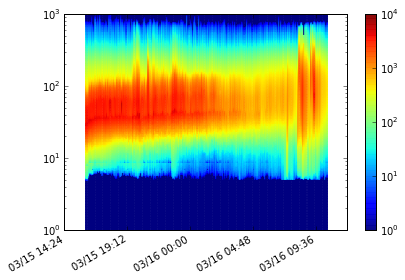

In [135]:
pmax = 10**np.ceil(np.log10(np.amax(Z[np.where(Z > 0)])))
pmin = 1#10**np.floor(np.log10(np.amin(Z[np.where(Z > 0)])))
fig, ax = plt.subplots()
pc = ax.pcolor(XI, YI, Z, cmap=plt.cm.jet, norm=colors.LogNorm(pmin, pmax, clip=False), alpha=0.8)

plt.colorbar(pc)
plt.yscale('log')
plt.ylim(1, 1000)
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
fig.tight_layout()

## Use of the SizeDistr Object

The ``sizeditribution`` package contains some classes and routines for ready manipulation of the data.  But first, we will need to convert the data of interest to a PANDAS data frame with the time as index.

In [170]:
dataframe = pd.DataFrame(hagis.dn_interp)
dataframe.index = hagis.date

In addition, we will need to convert the bin centers produced by the ``SMPS`` object to bin edges.  To do this, we will make the simple assumption that the bin edges are just the halfway points between the centers.  For the edge cases, we will simply take the difference between the smallest bin center and the halfway point between the first and second bin centers and subtract this value from the smallest diameter.  Similarly, for the largest diameter, we will take the difference between the halfway point between the largest and second largest bin centers and the largest bin center and add it to the largest bin center.

In [210]:
binedges = (hagis.diam_interp[1:]+hagis.diam_interp[:-1])/2
first = hagis.diam_interp[0] -(binedges[0]-hagis.diam_interp[0])
last = hagis.diam_interp[-1]+ (hagis.diam_interp[-1]-binedges[-1])
binedges = np.append([first],binedges)
binedges=np.append(binedges,[last])
sizeDistr = sd.SizeDist_TS(dataframe,binedges, 'dNdlogDp')

(5, 1000)

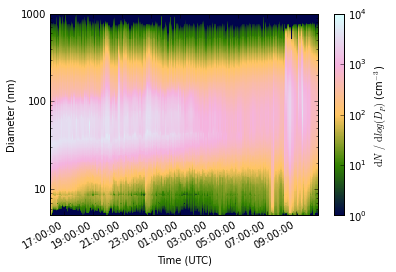

In [211]:
f,a,b,c = sizeDistr.plot(vmax = pmax, vmin = pmin, norm='log', showMinorTickLabels=False)
a.set_ylim((5,1000))

Once we have the corresponding ``SizeDistr`` object, we can now change the current distribution which is in $dN/d\log D_p$ space and change this to a surface area distribution in log space.  This will produce a new object that we will call ``sfSD``.

In [212]:
sfSD = sizeDistr.convert2dSdlogDp()

(5, 1000)

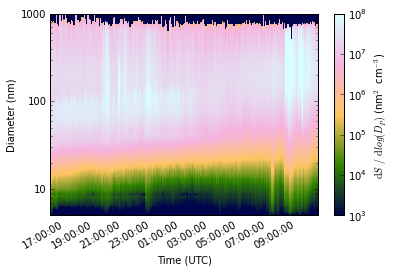

In [213]:
f,a,b,c = sfSD.plot(vmax = 1e8, vmin = 1e3, norm='log', showMinorTickLabels=False,removeTickLabels=['200','300','400',])
a.set_ylim((5,1000))

To get an overall view, we can further manipulate the data to produce average distributions from the entire time series.

In [214]:
avgAt = sizeDistr.average_overAllTime()

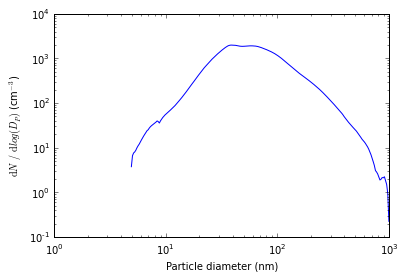

In [216]:
f,a = avgAt.plot(norm='log')
# a.set_yscale('log')

In [191]:
avgAtS = sfSD.average_overAllTime()

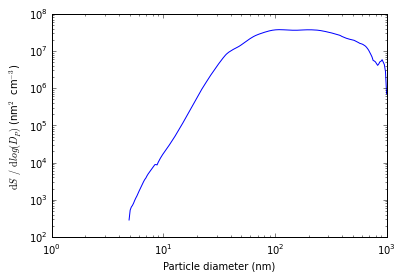

In [207]:
f,a= avgAtS.plot(norm='log')
a.set_yscale('log')

In the previous analysis, it appears that we have a size distribution which centers around 60 nm in number and somewhere around 100 to 200 nm in surface.